# Access Log Exploratory Data Analysis (EDA)

This notebook performs a comprehensive analysis of the server access logs (`data/access_log.txt`). 
We will load the data, calculate key performance metrics, analyze traffic patterns, and examine correlations between different traffic features.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from datetime import datetime

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading and Parsing

We extract structured fields (IP, Timestamp, Method, URL, Status, Size) using regex from the raw log lines.

In [8]:
log_file_path = 'data/access_log.txt'

log_pattern = re.compile(r'(?P<ip>\S+) - - \[(?P<timestamp>.*?)\] "(?P<method>\S+) (?P<url>\S+) \S+" (?P<status>\d{3}) (?P<size>\d+|-)')

data = []

try:
    with open(log_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            match = log_pattern.match(line)
            if match:
                data.append(match.groupdict())
except FileNotFoundError:
    print(f"File not found: {log_file_path}")

df = pd.DataFrame(data)

if not df.empty:
    # Convert columns
    df['status'] = df['status'].astype(int)
    df['size'] = df['size'].replace('-', 0).astype(int)
    # Fix timestamp parsing with utc=True
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce', utc=True)
    
    # Feature Engineering
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.day_name()
    df['is_error'] = df['status'] >= 400
    
    print(f"Loaded {len(df)} records.")
    display(df.head())
else:
    print("No data found.")

Loaded 4453375 records.


,ip,timestamp,method,url,status,size,hour,day_of_week,is_error
0,10.223.157.186,2009-07-15 21:58:59+00:00,GET,/,403,202,21,Wednesday,True
1,10.223.157.186,2009-07-15 21:58:59+00:00,GET,/favicon.ico,404,209,21,Wednesday,True
2,10.223.157.186,2009-07-15 22:50:35+00:00,GET,/,200,9157,22,Wednesday,False
3,10.223.157.186,2009-07-15 22:50:35+00:00,GET,/assets/js/lowpro.js,200,10469,22,Wednesday,False
4,10.223.157.186,2009-07-15 22:50:35+00:00,GET,/assets/css/reset.css,200,1014,22,Wednesday,False


## 2. Key Performance Metrics

Overview of the system's traffic health.

In [9]:
if not df.empty:
    total_requests = len(df)
    unique_visitors = df['ip'].nunique()
    total_bandwidth_mb = df['size'].sum() / (1024 * 1024)
    error_rate = (df['is_error'].mean()) * 100
    avg_response_size = df['size'].mean()

    metrics = pd.DataFrame({
        'Metric': ['Total Requests', 'Unique Visitors (IPs)', 'Total Bandwidth (MB)', 'Error Rate (%)', 'Avg Response Size (Bytes)'],
        'Value': [total_requests, unique_visitors, f"{total_bandwidth_mb:.2f}", f"{error_rate:.2f}%", f"{avg_response_size:.2f}"]
    })
    
    display(metrics)

,Metric,Value
0,Total Requests,4453375
1,Unique Visitors (IPs),333917
2,Total Bandwidth (MB),767853.49
3,Error Rate (%),1.91%
4,Avg Response Size (Bytes),180796.08


## 3. Traffic Analysis & Heatmap

When are the busiest times? We visualize the request density by Hour of Day and Day of Week.

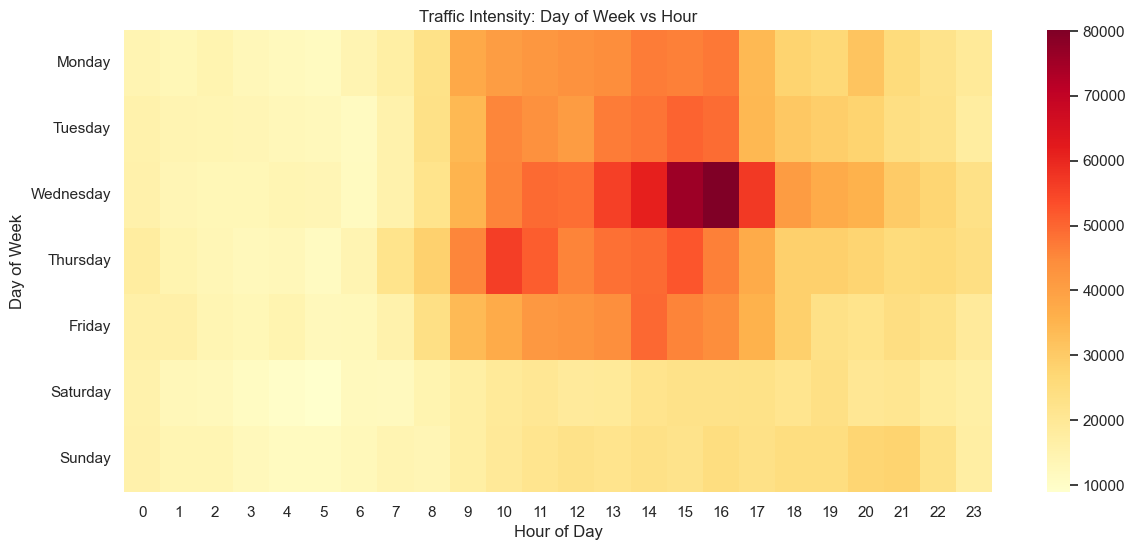

In [10]:
if not df.empty:
    # Aggregating data for heatmap
    heatmap_data = df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)
    
    # Reorder days
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    heatmap_data = heatmap_data.reindex(days_order)
    
    plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, fmt="d")
    plt.title('Traffic Intensity: Day of Week vs Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.show()

## 4. Status Code & Error Analysis

Distribution of HTTP status codes to identify potential server or client issues.

C:\Users\MSI\AppData\Local\Temp\ipykernel_27788\4141947077.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df, palette='viridis', ax=ax[0])


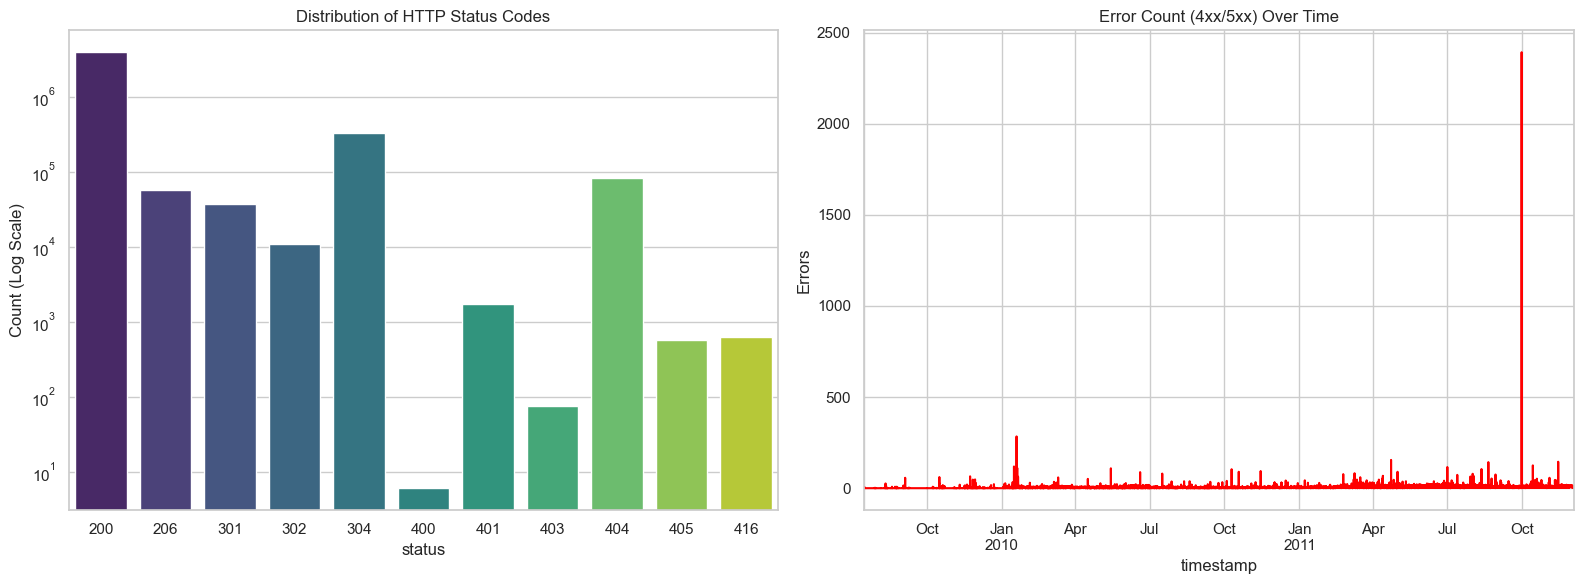

In [11]:
if not df.empty:
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Count plot
    sns.countplot(x='status', data=df, palette='viridis', ax=ax[0])
    ax[0].set_title('Distribution of HTTP Status Codes')
    ax[0].set_yscale('log') # Log scale to see errors better if 200s dominate
    ax[0].set_ylabel('Count (Log Scale)')
    
    # Error requests over time
    errors_over_time = df[df['is_error']].set_index('timestamp').resample('H').size()
    if not errors_over_time.empty:
        errors_over_time.plot(ax=ax[1], color='red')
        ax[1].set_title('Error Count (4xx/5xx) Over Time')
        ax[1].set_ylabel('Errors')
    
    plt.tight_layout()
    plt.show()

## 5. Correlation Analysis

We resample the data into hourly buckets to analyze the correlation between traffic volume, bandwidth usage, unique users per hour, and error rates.

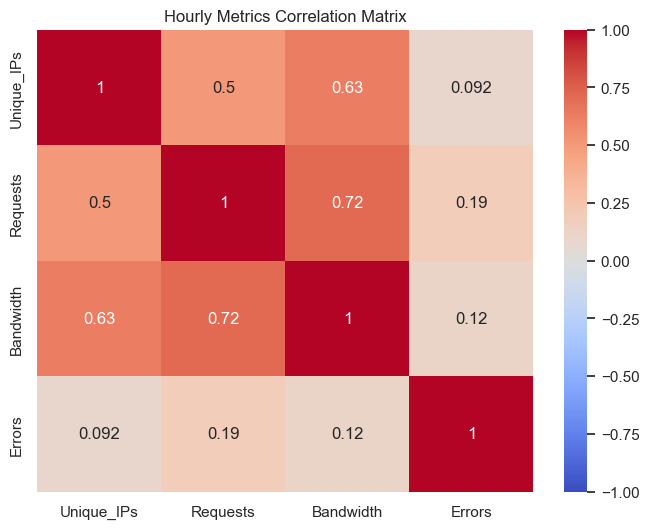

,Unique_IPs,Requests,Bandwidth,Errors
Unique_IPs,1.000000,0.501967,0.629352,0.091945
Requests,0.501967,1.000000,0.715870,0.187026
Bandwidth,0.629352,0.715870,1.000000,0.115082
Errors,0.091945,0.187026,0.115082,1.000000


In [12]:
if not df.empty:
    # Create hourly aggregated features
    hourly_stats = df.set_index('timestamp').resample('H').agg({
        'ip': pd.Series.nunique,          # Unique Visitors
        'status': 'count',                # Total Requests
        'size': 'sum',                    # Total Bandwidth
        'is_error': 'sum'                 # Total Errors
    }).rename(columns={
        'ip': 'Unique_IPs',
        'status': 'Requests',
        'size': 'Bandwidth',
        'is_error': 'Errors'
    })
    
    # Calculate correlation matrix
    corr_matrix = hourly_stats.corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Hourly Metrics Correlation Matrix')
    plt.show()
    
    display(corr_matrix)

## 6. Response Size Distribution

Understanding the distribution of data returned to clients.

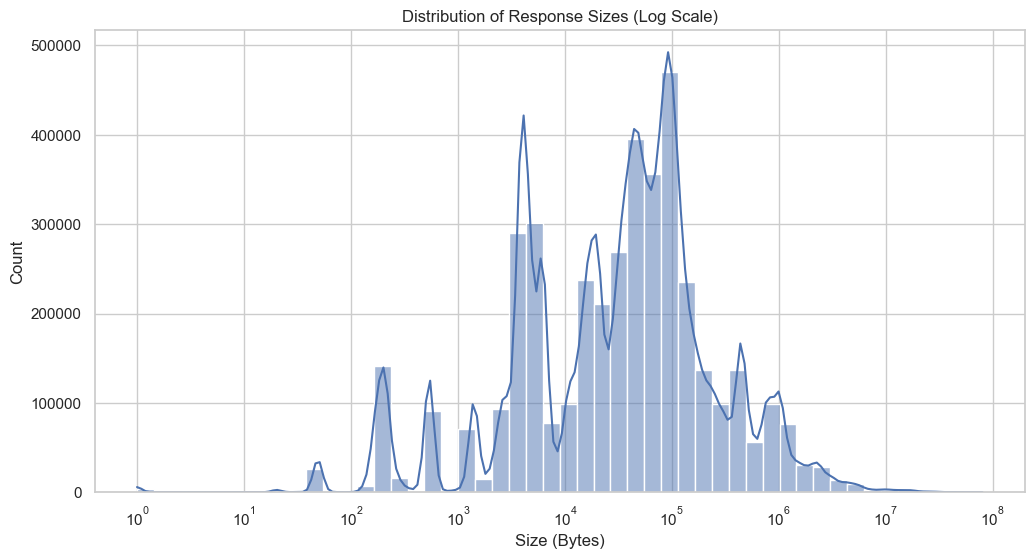

In [13]:
if not df.empty:
    plt.figure(figsize=(12, 6))
    # Filter out 0 bytes for log scale visualization
    sns.histplot(df[df['size'] > 0]['size'], bins=50, log_scale=True, kde=True)
    plt.title('Distribution of Response Sizes (Log Scale)')
    plt.xlabel('Size (Bytes)')
    plt.show()

## 7. Top Resources & Visitors

Identifying the most popular pages and most active IP addresses.

C:\Users\MSI\AppData\Local\Temp\ipykernel_27788\1489989986.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_urls.values, y=top_urls.index, palette='Blues_r', ax=ax[0])
C:\Users\MSI\AppData\Local\Temp\ipykernel_27788\1489989986.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ips.values, y=top_ips.index, palette='magma', ax=ax[1])


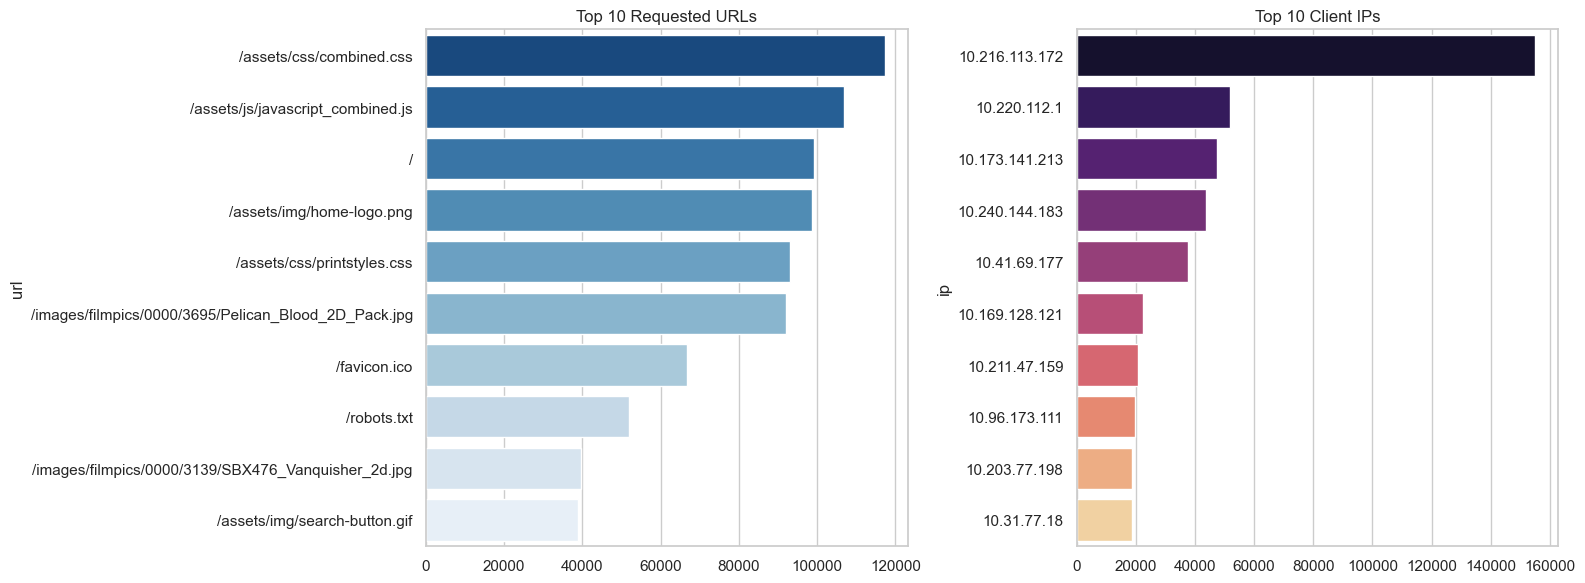

In [14]:
if not df.empty:
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top URLs
    top_urls = df['url'].value_counts().head(10)
    sns.barplot(x=top_urls.values, y=top_urls.index, palette='Blues_r', ax=ax[0])
    ax[0].set_title('Top 10 Requested URLs')
    
    # Top IPs
    top_ips = df['ip'].value_counts().head(10)
    sns.barplot(x=top_ips.values, y=top_ips.index, palette='magma', ax=ax[1])
    ax[1].set_title('Top 10 Client IPs')
    
    plt.tight_layout()
    plt.show()